In [1]:
import numpy as np
import qutip as qu
import scipy
import solve_lindblad
import matplotlib.pyplot as plt


In [2]:
def comp_probs(rho, projs):
    return np.abs(np.real([np.trace(proj_i @ rho) for proj_i in projs]))


In [163]:
def partial_rho_gamma(rho0, H0, operators, t, bare_jump_op, no_qubits=1):
    liouvillian = qu.liouvillian(H0, c_ops=operators)
    dissipator = qu.lindblad_dissipator(bare_jump_op)

    print(dissipator)
    rho_sup = qu.to_super(rho0)
    rho_evol = (
        
            t*scipy.linalg.expm(liouvillian.full() * t) @ dissipator.full()  @rho_sup.full() 
       
        
    )
    # print(rho_evol)
    dm_evol = rho_evol[:, 0].reshape(-1, 2**no_qubits)
    print(dm_evol)
    dm_evol = qu.Qobj(dm_evol)
    return dm_evol


In [164]:
def partial_prob(projectors, rho0, H0, operators, t, bare_jump_op):
    return [
        np.trace(
            proj_i @ partial_rho_gamma(rho0, H0, operators, t, bare_jump_op).full()
        )
        for proj_i in projectors
    ]


In [165]:
def fisher_inf(projectors, rho0, H0, operators, t, bare_jump_op):
    return np.sum(
        np.array(
            partial_prob(
                projectors=projectors,
                rho0=rho0,
                H0=H0,
                operators=operators,
                t=t,
                bare_jump_op=bare_jump_op,
            )
        )
        ** 2
        / np.array(
            comp_probs(
                solve_lindblad.evolve_dm(rho0, H0, operators, t).full(), projectors
            )
        )
    )


In [166]:
J = 0.3
c_ops = [J * qu.sigmax()]

H0 = 0.2*qu.sigmax()
psi0 = qu.basis(2, 0)
rho0 = qu.ket2dm(psi0)

projs = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])]


In [182]:
dj = 0.0000001
J = 0.4
t = 10
a = partial_rho_gamma(rho0, H0, [J*qu.sigmax()], t, qu.sigmax())
now = solve_lindblad.evolve_dm(rho0, H0, [J*qu.sigmax()], t)
before = solve_lindblad.evolve_dm(rho0, H0, [(J-dj)*qu.sigmax()], t)
after = solve_lindblad.evolve_dm(rho0, H0, [(J+dj)*qu.sigmax()], t )

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[-1.  0.  0.  1.]
 [ 0. -1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 1.  0.  0. -1.]]
[[ 0.00488001+0.j          0.        -0.00565018j]
 [ 0.        +0.00565018j -0.00488001+0.j        ]]


In [183]:
partial = np.linalg.det(now.full())*np.trace(np.linalg.inv(now.full())@a.full() )

In [184]:
(np.linalg.det(after) - np.linalg.det(before))/(2*dj)

(6.689926390635037e-06+0j)

In [185]:
partial

(5.573903690918647e-06+0j)

In [186]:
comp_probs(rho0.full(), projs)

array([1., 0.])

In [346]:
projs[0]

array([[1, 0],
       [0, 0]])

In [386]:
# fisher_inf(rho=rho0, projectors=projs,  rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t, bare_jump_op=qu.sigmax() )

/tmp/ipykernel_30185/3862949155.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.array(partial_prob(projectors, **kwargs))**2  / np.array(comp_probs(rho.full(), projectors)))
/tmp/ipykernel_30185/3862949155.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.array(partial_prob(projectors, **kwargs))**2  / np.array(comp_probs(rho.full(), projectors)))


(inf+nanj)

In [392]:
comp_probs(rho0.full(), projs)

array([1., 0.])

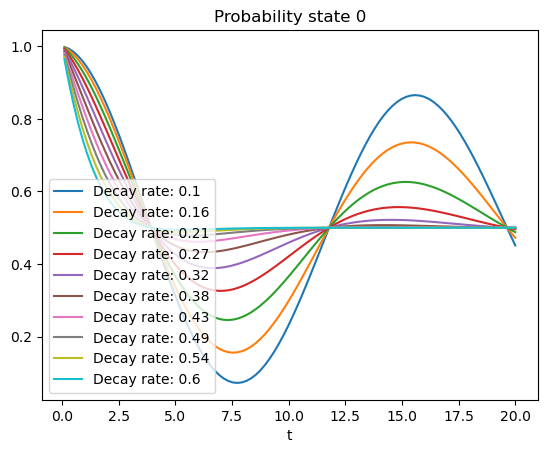

In [464]:
# t_list = np.linspace(0.01, 50, 500)
# J = 0.5

# y = [comp_probs( solve_lindblad.evolve_dm(  rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t ).full(), projs)[0] for t in t_list]
# plt.plot(t_list, y )


J_list = np.linspace(0.1, 0.6, 10)
t_list = np.linspace(0.1, 20, 100)
for J in J_list:
    y = [comp_probs( solve_lindblad.evolve_dm(  rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t ).full(), projs)[0] for t in t_list]
    plt.plot(t_list, y, label=f'Decay rate: {np.round(J, 2)}')

plt.legend()
plt.title(f"Probability state 0")
plt.xlabel("t")
# plt.ylabel("F(t)")
# plt.yscale('log')
plt.show()    

/home/antonio/miniconda3/envs/qinfer/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


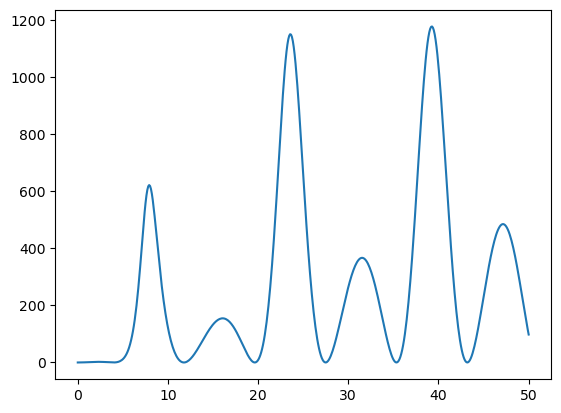

In [465]:
t_list = np.linspace(0.01, 50, 500)
J = 0.100

y = [fisher_inf(projectors=projs,  rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t, bare_jump_op=qu.sigmax() ) for t in t_list]
plt.plot(t_list, y)


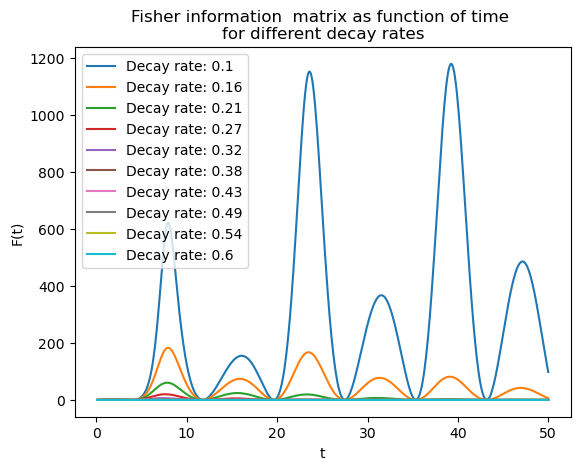

In [466]:
J_list = np.linspace(0.1, 0.6, 10)
t_list = np.linspace(0.1, 50, 500)
for J in J_list:
    y = [fisher_inf(projectors=projs,  rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t, bare_jump_op=qu.sigmax() ) for t in t_list]
    plt.plot(t_list, y, label=f'Decay rate: {np.round(J, 2)}')

plt.legend()
plt.title(f"Fisher information  matrix as function of time \nfor different decay rates")
plt.xlabel("t")
plt.ylabel("F(t)")
# plt.yscale('log')
plt.show()    

In [320]:
partial_prob(projs, rho0=rho0, H0=H0, operators=[J*qu.sigmax()], t=t, bare_jump_op=qu.sigmax())

[(-1.5399466897868468+0j), (1.5399466897868477+0j)]

In [192]:
qu.lindblad_dissipator(qu.sigmax()).full()

array([[-1.+0.j,  0.+0.j,  0.+0.j,  1.+0.j],
       [ 0.+0.j, -1.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j, -1.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [273]:
(after.full() - before.full())/(2*dj)


array([[-0.21199029+0.j        ,  0.        +0.07025134j],
       [ 0.        -0.07025134j,  0.21199029+0.j        ]])

In [274]:
print(a.full())

[[-0.35331715+0.j          0.        +0.11708556j]
 [ 0.        -0.11708556j  0.35331715+0.j        ]]


In [221]:
before.full()

array([[0.50000002+0.00000000e+00j, 0.        -1.77775377e-08j],
       [0.        +1.77775377e-08j, 0.49999998+0.00000000e+00j]])

In [222]:
a.full()

array([[-1.06108291e-08+0.00000000e+00j,  0.00000000e+00+1.09253187e-08j],
       [ 0.00000000e+00-1.09253187e-08j,  1.06108289e-08+0.00000000e+00j]])